In [61]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [62]:
v_medie = pd.read_csv('./export_5t/export_polito_velocita_medie_feriali_nov2024.csv')
traffico = pd.read_csv('./polito_sensors_vittorio/polito_sensors_vittorio_data.csv', index_col=0)
pioggia = pd.read_csv('./meteo/TORINO GIARDINI REALI_p.csv', index_col=0)

In [3]:
pioggia.drop(columns=['Precipitazione classe'], inplace=True)
pioggia.index = pd.to_datetime(pioggia.index, utc=True)
pioggia.rename({'Precipitazione (mm)': 'precip'}, axis=1, inplace=True)

In [4]:
pioggia.head()

,precip
DATA,
2024-01-01 00:00:00+00:00,0.0
2024-01-02 00:00:00+00:00,0.2
2024-01-03 00:00:00+00:00,0.0
2024-01-04 00:00:00+00:00,0.0
2024-01-05 00:00:00+00:00,23.6


In [5]:
traffico.info()

<class 'pandas.core.frame.DataFrame'>
Index: 44870 entries, 0 to 4373
Data columns (total 10 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   device_id                44870 non-null  int64  
 1   data_location_id         44870 non-null  object 
 2   timestamp_record         44870 non-null  object 
 3   key                      44870 non-null  object 
 4   value                    44870 non-null  float64
 5   accuracy                 44870 non-null  int64  
 6   quality_automatic_check  6121 non-null   object 
 7   quality_manual_check     0 non-null      float64
 8   id_local                 44870 non-null  int64  
 9   id_global                44870 non-null  object 
dtypes: float64(2), int64(3), object(5)
memory usage: 3.8+ MB


In [6]:
traffico.describe()

,device_id,value,accuracy,quality_manual_check,id_local
count,44870.000000,44870.000000,44870.000000,0.0,44870.000000
mean,44048.416046,333.057366,77.339492,NaN,44048.416046
std,35628.695902,238.766144,27.632698,NaN,35628.695902
min,1143.000000,0.000000,0.000000,NaN,1143.000000
25%,1145.000000,98.000000,75.000000,NaN,1145.000000
50%,73223.000000,334.000000,82.000000,NaN,73223.000000
75%,73225.000000,524.000000,98.000000,NaN,73225.000000
max,75176.000000,910.000000,100.000000,NaN,75176.000000


In [7]:
traffico.head()

,device_id,data_location_id,timestamp_record,key,value,accuracy,quality_automatic_check,quality_manual_check,id_local,id_global
0,73224,pasta,2024-03-31 22:00:00+00:00,count_all,61.0,80,NaN,NaN,73224,car-73224
1,1143,pasta,2024-03-31 22:00:00+00:00,count_all,116.0,98,NaN,NaN,1143,car-1143
2,73223,pasta,2024-03-31 22:00:00+00:00,count_all,53.0,80,NaN,NaN,73223,car-73223
3,73225,pasta,2024-03-31 22:00:00+00:00,count_all,116.0,80,NaN,NaN,73225,car-73225
4,1145,pasta,2024-03-31 22:00:00+00:00,count_all,217.0,100,NaN,NaN,1145,car-1145


In [8]:
traffico.drop(columns=['data_location_id', 'quality_automatic_check', 'quality_manual_check', 'id_global', 'id_local'], inplace=True)

In [9]:
traffico.head()

,device_id,timestamp_record,key,value,accuracy
0,73224,2024-03-31 22:00:00+00:00,count_all,61.0,80
1,1143,2024-03-31 22:00:00+00:00,count_all,116.0,98
2,73223,2024-03-31 22:00:00+00:00,count_all,53.0,80
3,73225,2024-03-31 22:00:00+00:00,count_all,116.0,80
4,1145,2024-03-31 22:00:00+00:00,count_all,217.0,100


In [10]:
# --- Parametri dei bin di pioggia
bins   = [0, 0.1, 5, 10, 15, 20, 25, 30, np.inf]
labels = ['0', '0.1-5', '5-10', '10-15', '15-20', '20-25', '25-30', '>30']

# --- Ciclo su ogni segmento
stats_per_segment = {}
daily_all = []   # per costruire le giornate di traffico+pioggia di tutti i segmenti

for device_id, group in traffico.groupby('device_id'):
    # 1) prepara il DataFrame del segment
    seg = group.copy()
    seg['timestamp_record'] = pd.to_datetime(seg['timestamp_record'], utc=True)
    seg.set_index('timestamp_record', inplace=True)
    
    # 2) media giornaliera traffico
    daily_traf = seg['value'].resample('D').mean().to_frame()
    
    # 3) unisci la pioggia
    df_seg = daily_traf.join(pioggia, how='left')
    
    # 4) crea il bin di pioggia
    df_seg['rain_bin'] = pd.cut(df_seg['precip'].fillna(0),
                                bins=bins, labels=labels, right=False)
    
    # 5) calcola stats per bin
    stats = (
        df_seg
        .groupby('rain_bin', observed=True)['value']
        .agg(mean_value='mean', std_value='std', n_days='count')
    )
    stats_per_segment[device_id] = stats
    
    # 6) salva i data giornalieri per il calcolo complessivo
    df_seg['device_id'] = device_id
    daily_all.append(df_seg)

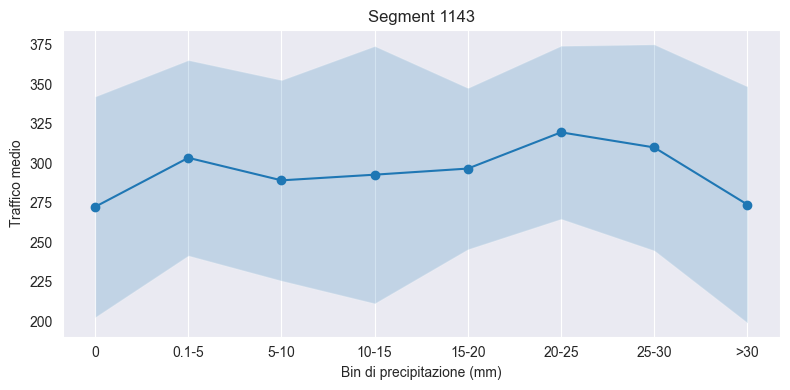

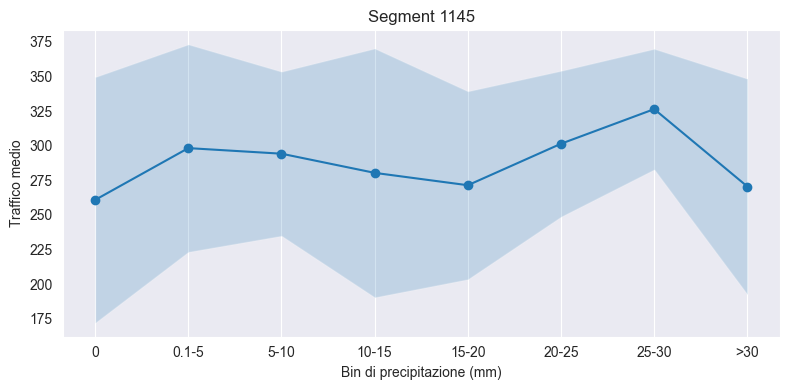

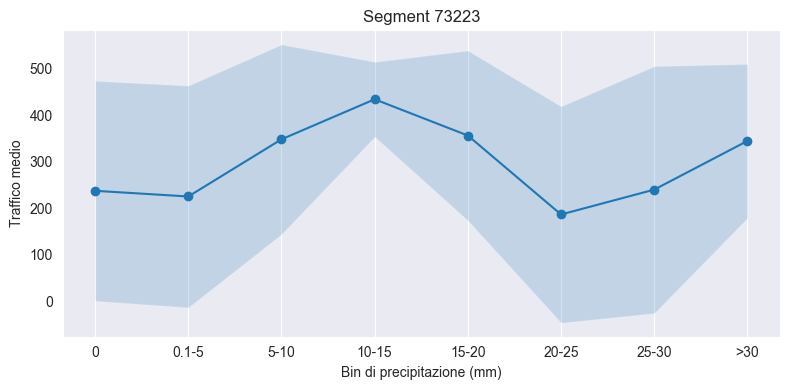

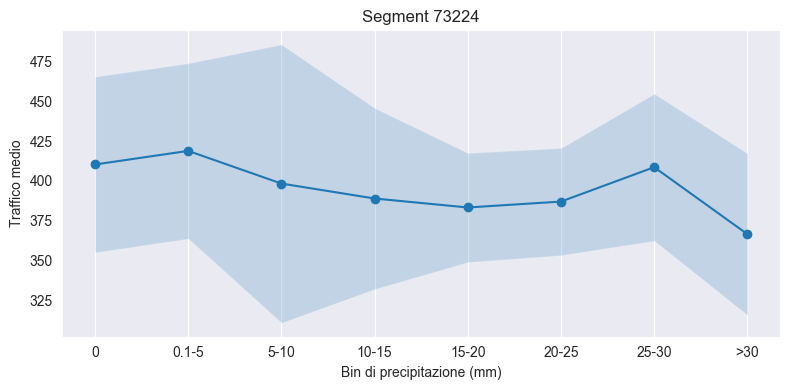

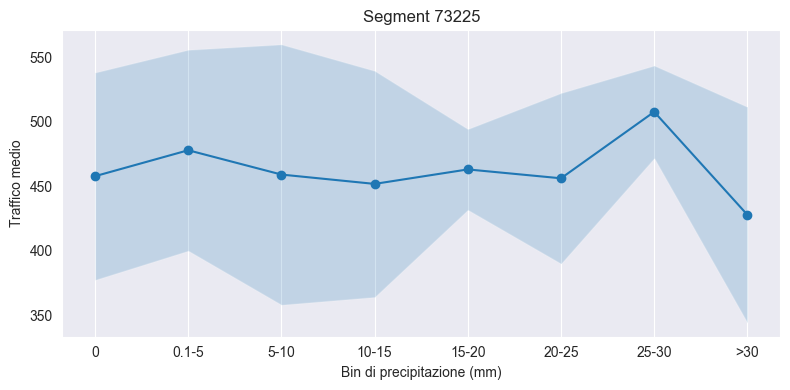

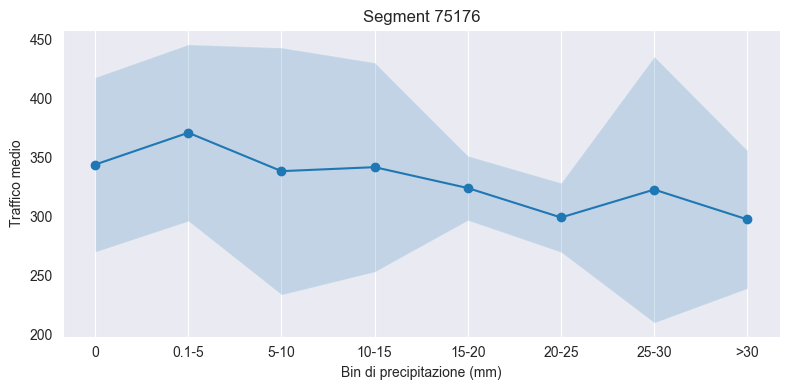

In [11]:
# --- Plot: un grafico a line+area di errore per ciascun segmento
for device_id, stats in stats_per_segment.items():
    x     = np.arange(len(stats))
    means = stats['mean_value']
    stds  = stats['std_value']
    
    fig, ax = plt.subplots(figsize=(8,4))
    ax.plot(x, means, marker='o', linestyle='-')
    ax.fill_between(x, means-stds, means+stds, alpha=0.2)
    ax.set_xticks(x)
    ax.set_xticklabels(stats.index)
    ax.set_title(f'Segment {device_id}')
    ax.set_xlabel('Bin di precipitazione (mm)')
    ax.set_ylabel('Traffico medio')
    ax.grid(axis='y')
    plt.tight_layout()
    plt.show()

In [12]:
# --- Statistiche complessive (su tutti i device insieme):
df_daily_all = pd.concat(daily_all)
overall_stats = (
    df_daily_all
    .groupby('rain_bin', observed=True)['value']
    .agg(mean_value='mean', std_value='std', n_days='count')
)
print(overall_stats)

          mean_value   std_value  n_days
rain_bin                                
0         325.583546  140.191914    1273
0.1-5     345.894877  133.726492     272
5-10      351.880730  125.476161     155
10-15     346.204933  103.152634      43
15-20     349.720249  101.560938      40
20-25     324.801948  127.503584      44
25-30     356.559896  149.014179      32
>30       322.332447  104.494658      47


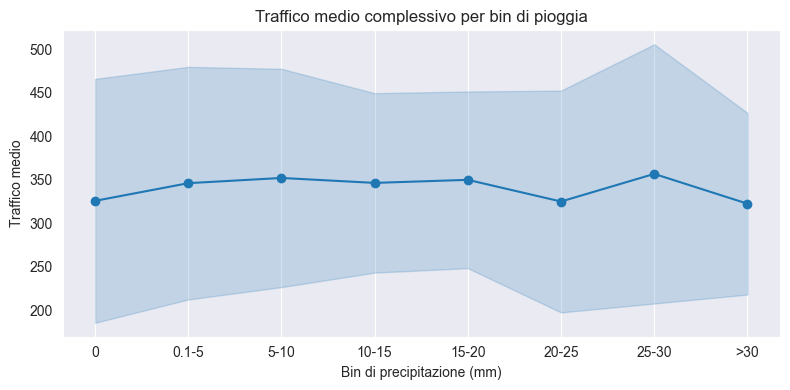

In [13]:
# --- Plot complessivo
x     = np.arange(len(overall_stats))
means = overall_stats['mean_value']
stds  = overall_stats['std_value']

fig, ax = plt.subplots(figsize=(8,4))
ax.plot(x, means, marker='o', linestyle='-')
ax.fill_between(x, means-stds, means+stds, alpha=0.2, color='tab:blue')
ax.set_xticks(x)
ax.set_xticklabels(overall_stats.index)
ax.set_title('Traffico medio complessivo per bin di pioggia')
ax.set_xlabel('Bin di precipitazione (mm)')
ax.set_ylabel('Traffico medio')
ax.grid(axis='y')
plt.tight_layout()
plt.show()

       mean_value   std_value  n_days
Clear  325.583546  140.191914    1273
Rain   344.946871  126.194315     633


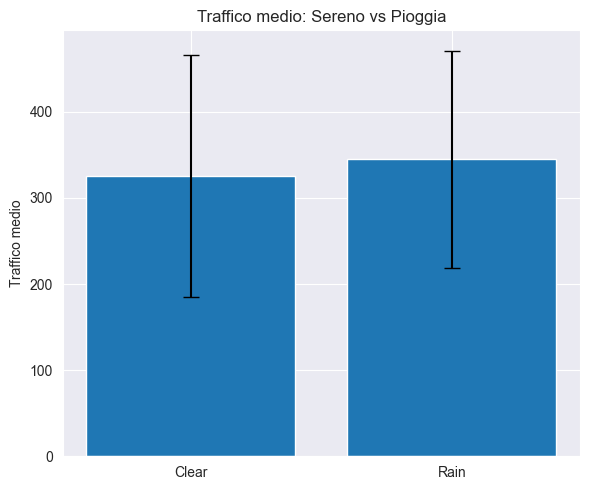

In [14]:
# 1) Flag booleano
df = df_daily_all.copy()
df['rain_flag'] = df['precip'] > 0

# 2) Statistiche aggregate
binary_stats = (
    df
    .groupby('rain_flag')['value']
    .agg(mean_value='mean', std_value='std', n_days='count')
)
binary_stats.index = ['Clear', 'Rain']

print(binary_stats)

# 3) Grafico a barre con barre di errore
fig, ax = plt.subplots(figsize=(6, 5))
ax.bar(
    binary_stats.index,
    binary_stats['mean_value'],
    yerr=binary_stats['std_value'],
    capsize=6
)
ax.set_title('Traffico medio: Sereno vs Pioggia')
ax.set_ylabel('Traffico medio')
ax.grid(True, axis='y')
plt.tight_layout()
plt.show()

           clear_mean   clear_std     clear_n   rain_mean  rain_std  rain_n
weekday                                                                    
Monday     305.524928  351.516019  133.035269  104.925731       191      83
Tuesday    327.811279  344.397054  140.512322  126.806784       155     117
Wednesday  331.952903  354.583905  141.723800  121.972205       177      90
Thursday   339.746708  359.353600  143.121200  138.192242       162     115
Friday     356.170920  379.475163  158.736845  125.417059       191      84
Saturday   338.705752  347.073175  136.953294  127.121995       211      56
Sunday     279.632552  276.487013  111.792801  109.984043       186      88


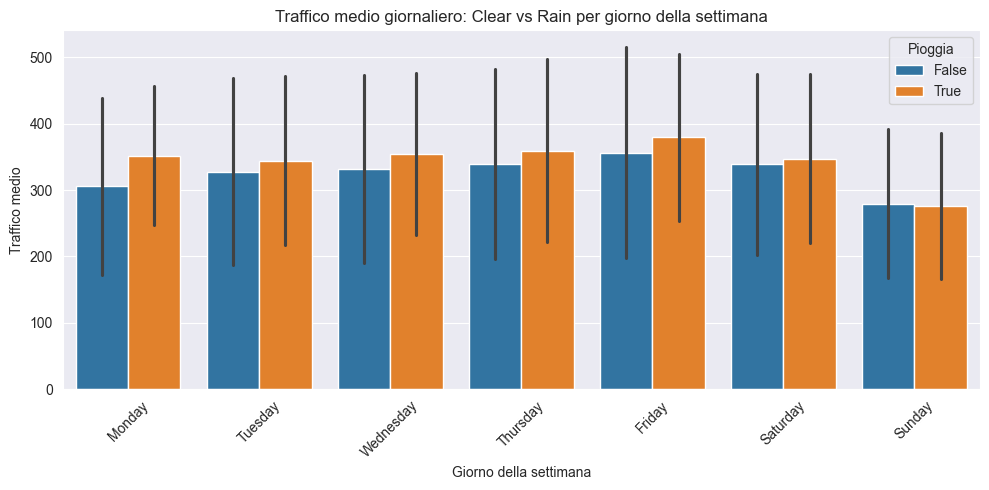

In [15]:
# 1) Analisi per giorno della settimana
df_wd = df_daily_all.copy()
df_wd['weekday'] = df_wd.index.day_name()
df_wd['rain_flag'] = df_wd['precip'] > 0

# Statistiche aggregate per weekday e condizione meteo
weekday_stats = (
    df_wd
    .groupby(['weekday', 'rain_flag'])['value']
    .agg(mean_value='mean', std_value='std', n_days='count')
    .unstack('rain_flag')
)

# Rinomina colonne e riordina i giorni
weekday_stats.columns = ['clear_mean', 'clear_std', 'clear_n', 'rain_mean', 'rain_std', 'rain_n']
weekday_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
weekday_stats = weekday_stats.reindex(weekday_order)

print(weekday_stats)

# Grafico comparativo con seaborn
plt.figure(figsize=(10, 5))
sns.barplot(
    data=df_wd.reset_index(),
    x='weekday', y='value', hue='rain_flag',
    errorbar='sd', order=weekday_order
)
plt.title('Traffico medio giornaliero: Clear vs Rain per giorno della settimana')
plt.xlabel('Giorno della settimana')
plt.ylabel('Traffico medio')
plt.xticks(rotation=45)
plt.legend(title='Pioggia')
plt.tight_layout()
plt.show()

        clear_mean   clear_std     clear_n   rain_mean  rain_std  rain_n
season                                                                  
Winter  293.853809  325.578885  134.683553  114.387270       413      74
Spring  387.928632  370.493228  115.831946  103.221039       207     174
Summer  319.236913  343.752435  143.183885  127.236693       362     166
Autumn  334.162343  332.099569  145.088271  142.347361       291     219


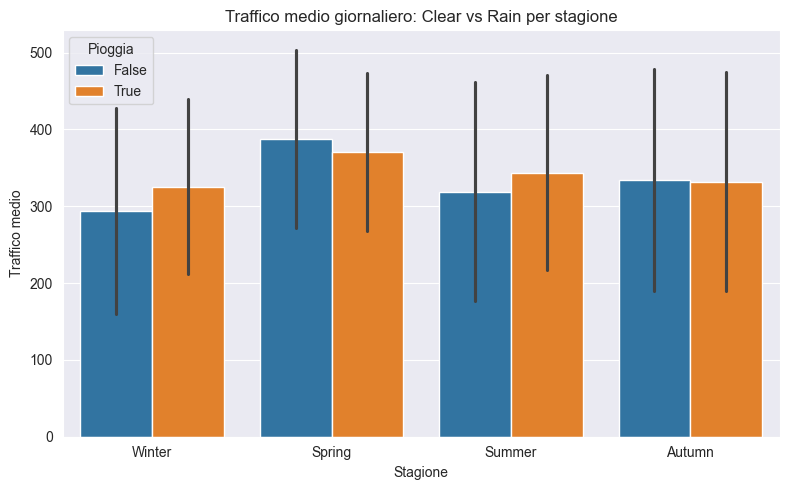

In [16]:
# 3) Analisi per stagione
def month_to_season(m):
    if m in (12, 1, 2):
        return 'Winter'
    if m in (3, 4, 5):
        return 'Spring'
    if m in (6, 7, 8):
        return 'Summer'
    return 'Autumn'


df_season = df_daily_all.copy()
df_season['season'] = df_season.index.month.map(month_to_season)
df_season['rain_flag'] = df_season['precip'] > 0

# Statistiche aggregate per stagione e condizione meteo
season_stats = (
    df_season
    .groupby(['season', 'rain_flag'])['value']
    .agg(mean_value='mean', std_value='std', n_days='count')
    .unstack('rain_flag')
)
season_stats.columns = ['clear_mean', 'clear_std', 'clear_n', 'rain_mean', 'rain_std', 'rain_n']
season_order = ['Winter', 'Spring', 'Summer', 'Autumn']
season_stats = season_stats.reindex(season_order)

print(season_stats)

# Grafico comparativo per stagione
plt.figure(figsize=(8, 5))
sns.barplot(
    data=df_season.reset_index(),
    x='season', y='value', hue='rain_flag',
    errorbar='sd', order=season_order
)
plt.title('Traffico medio giornaliero: Clear vs Rain per stagione')
plt.xlabel('Stagione')
plt.ylabel('Traffico medio')
plt.legend(title='Pioggia')
plt.tight_layout()
plt.show()

   threshold  delta_mean
0          5    5.297466
1         10    1.357232
2         15   -1.466794
3         20   -6.082014
4         25   -1.646084
5         30  -15.868803


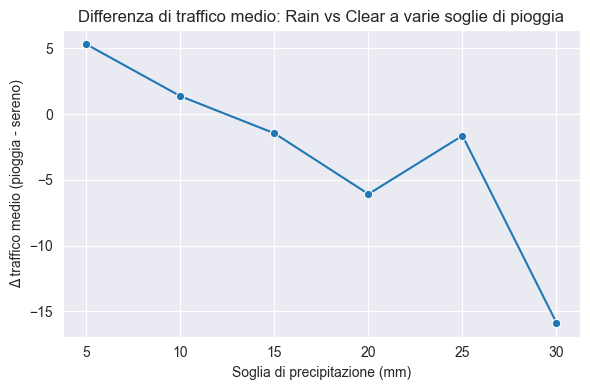

In [17]:
# 4) Soglie critiche (delta medio traffico per soglia)
thresholds = [5, 10, 15, 20, 25, 30]
delta = []
for t in thresholds:
    clear_vals = df_daily_all[df_daily_all['precip'] <= t]['value']
    rain_vals = df_daily_all[df_daily_all['precip'] > t]['value']
    delta.append({'threshold': t, 'delta_mean': rain_vals.mean() - clear_vals.mean()})

crit_df = pd.DataFrame(delta)
print(crit_df)

# Line plot del delta medio
plt.figure(figsize=(6, 4))
sns.lineplot(data=crit_df, x='threshold', y='delta_mean', marker='o')
plt.title('Differenza di traffico medio: Rain vs Clear a varie soglie di pioggia')
plt.xlabel('Soglia di precipitazione (mm)')
plt.ylabel('Δ traffico medio (pioggia - sereno)')
plt.grid(True)
plt.tight_layout()
plt.show()

In [18]:
from scipy.stats import ttest_ind

# Copia e prepara dati
df_bt = df_daily_all.copy()
df_bt['precip'] = df_bt['precip'].fillna(0)  # riempi NaN con 0
df_bt['rain_flag'] = df_bt['precip'] > 0  # crea flag booleano

# Estrai i due gruppi
clear_vals = df_bt.loc[~df_bt['rain_flag'], 'value']
rain_vals = df_bt.loc[df_bt['rain_flag'], 'value']

print(f"# giorni Clear: {len(clear_vals)}, # giorni Rain: {len(rain_vals)}")

# Esegui il t-test di Welch, saltando eventuali NaN
t_stat, p_val = ttest_ind(clear_vals, rain_vals, equal_var=False, nan_policy='omit')
print(f"t-statistic: {t_stat:.3f}, p-value: {p_val:.4f}")

# giorni Clear: 1346, # giorni Rain: 678
t-statistic: -3.039, p-value: 0.0024


In [19]:
d = (rain_vals.mean() - clear_vals.mean()) / \
    np.sqrt((clear_vals.var(ddof=1) + rain_vals.var(ddof=1)) / 2)
print(f"Cohen’s d = {d:.2f}")

Cohen’s d = 0.15


# Uso Velocità Medie e Dati Meteo presi da OpenWeather 

In [20]:
v_medie

,idno,tail,head,ora,vel_media
0,892058820,65181913,929221967,0,30
1,892058820,65181913,929221967,1,30
2,892058820,65181913,929221967,2,30
3,892058820,65181913,929221967,3,30
4,892058820,65181913,929221967,4,30
...,...,...,...,...,...
61891,55226373,65174777,65174776,19,29
61892,55226373,65174777,65174776,20,29
61893,55226373,65174777,65174776,21,29
61894,55226373,65174777,65174776,22,29


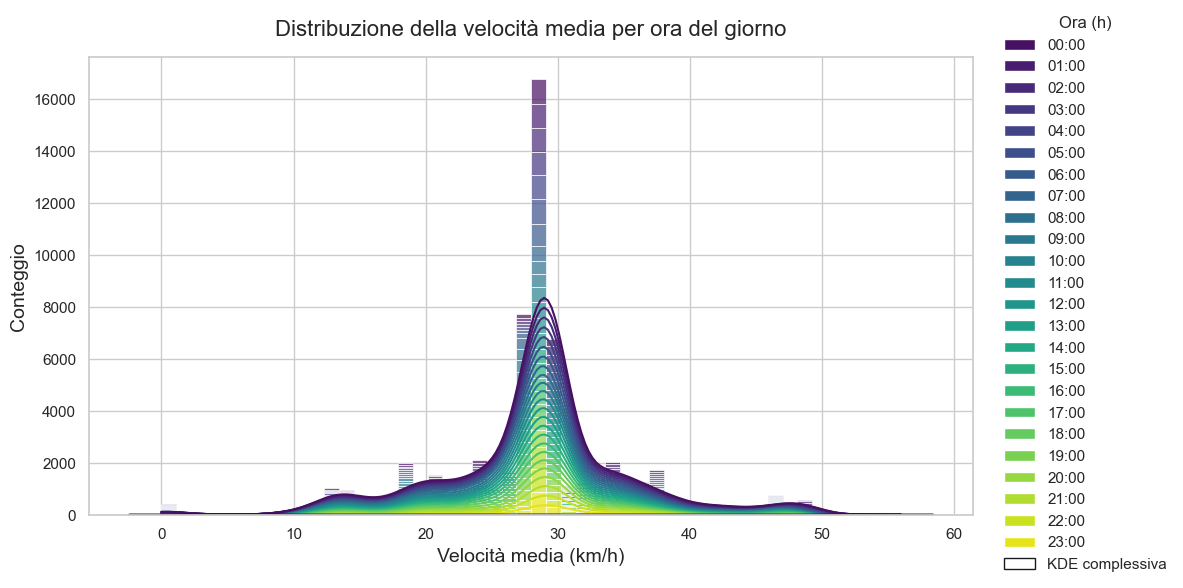

In [46]:
from matplotlib.patches import Patch

# Stile e dimensioni
sns.set_theme(style="whitegrid")
plt.figure(figsize=(12, 6))

# Ordine delle ore e palette
hue_order = list(range(24))
palette = sns.color_palette("viridis", 24)

# Istogramma impilato per ora
sns.histplot(
    data=v_medie,
    x="vel_media",
    bins=50,
    binrange=(v_medie.vel_media.min(), v_medie.vel_media.max()),
    stat="count",
    kde=True,
    hue="ora",
    hue_order=hue_order,
    palette=palette,
    alpha=0.7,
    edgecolor="white",
    linewidth=0.5,
    multiple="stack"
)

# KDE complessiva (senza hue)
sns.kdeplot(
    data=v_medie,
    x="vel_media",
    color="k",
    linewidth=2,
    label="KDE complessiva"
)

# Titoli ed etichette
plt.title("Distribuzione della velocità media per ora del giorno", fontsize=16, pad=15)
plt.xlabel("Velocità media (km/h)", fontsize=14)
plt.ylabel("Conteggio", fontsize=14)

# Costruzione manuale della legenda per le ore
legend_handles = [
    Patch(facecolor=palette[h], label=f"{h:02d}:00") for h in hue_order
] + [Patch(facecolor="none", edgecolor="k", label="KDE complessiva")]
plt.legend(
    handles=legend_handles,
    title="Ora (h)",
    bbox_to_anchor=(1.02, 1.12),
    loc="upper left",
    frameon=False
)

plt.tight_layout()
plt.show()

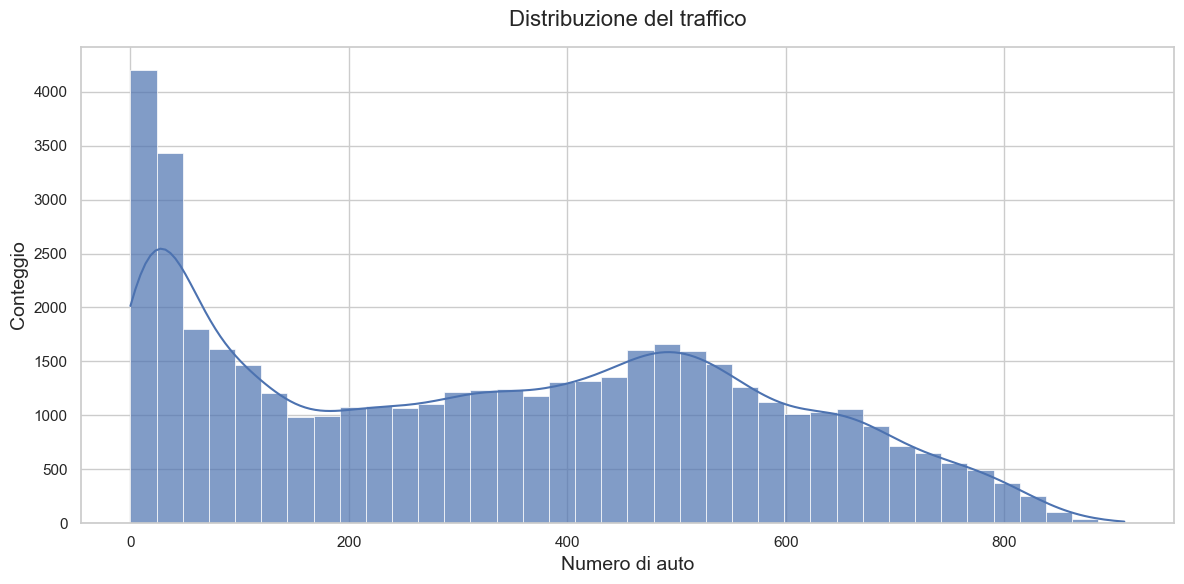

In [54]:
# Stile e dimensioni
sns.set_theme(style="whitegrid")
plt.figure(figsize=(12, 6))

# Istogramma impilato per ora
sns.histplot(
    data=traffico,
    x="value",
    stat="count",
    kde=True,
    alpha=0.7,
    edgecolor="white",
    linewidth=0.5
)

# Titoli ed etichette
plt.title("Distribuzione del traffico", fontsize=16, pad=15)
plt.xlabel("Numero di auto", fontsize=14)
plt.ylabel("Conteggio", fontsize=14)
plt.tight_layout()
plt.show()

In [90]:
segments = pd.DataFrame([
    {'device_id': 1143, 'length': 24, 'lanes': 2},
    {'device_id': 1145, 'length': 200, 'lanes': 2},
    {'device_id': 73223, 'length': 76, 'lanes': 1},
    {'device_id': 73224, 'length': 116, 'lanes': 1},
    {'device_id': 73225, 'length': 116, 'lanes': 1},
    {'device_id': 75176, 'length': 76, 'lanes': 1},
])
traffico = traffico.merge(segments, on='device_id', how='left')
traffico

,device_id,data_location_id,timestamp_record,key,value,accuracy,quality_automatic_check,quality_manual_check,id_local,id_global,length,lanes
0,73224,pasta,2024-03-31 22:00:00+00:00,count_all,61.0,80,NaN,NaN,73224,car-73224,116,1
1,1143,pasta,2024-03-31 22:00:00+00:00,count_all,116.0,98,NaN,NaN,1143,car-1143,24,2
2,73223,pasta,2024-03-31 22:00:00+00:00,count_all,53.0,80,NaN,NaN,73223,car-73223,76,1
3,73225,pasta,2024-03-31 22:00:00+00:00,count_all,116.0,80,NaN,NaN,73225,car-73225,116,1
4,1145,pasta,2024-03-31 22:00:00+00:00,count_all,217.0,100,NaN,NaN,1145,car-1145,200,2
...,...,...,...,...,...,...,...,...,...,...,...,...
44865,73223,pasta,2024-08-31 21:00:00+00:00,count_all,469.0,81,NaN,NaN,73223,car-73223,76,1
44866,1143,pasta,2024-08-31 21:00:00+00:00,count_all,322.0,100,NaN,NaN,1143,car-1143,24,2
44867,73224,pasta,2024-08-31 21:00:00+00:00,count_all,434.0,72,NaN,NaN,73224,car-73224,116,1
44868,1145,pasta,2024-08-31 21:00:00+00:00,count_all,80.0,93,NaN,NaN,1145,car-1145,200,2


In [91]:
traffico.columns

Index(['device_id', 'data_location_id', 'timestamp_record', 'key', 'value',
       'accuracy', 'quality_automatic_check', 'quality_manual_check',
       'id_local', 'id_global', 'length', 'lanes'],
      dtype='object')

In [95]:
# Copia i dati originali per non rischiare effetti collaterali
t = traffico.copy()

# Pipeline di trasformazioni
t = (
    t
    # 1) Converti timestamp e filtra per accuracy > 80
    .assign(timestamp_record=lambda d: pd.to_datetime(d['timestamp_record']))
    .query('accuracy > 80')
    # 2) Scegli solo le colonne di interesse
    [['timestamp_record', 'value', 'device_id', 'length', 'lanes']]
    # 3) estraggo l'ora del giorno da timestamp_record
    .assign(ora=lambda d: pd.to_datetime(d['timestamp_record']).dt.hour)
    # 4) raggruppo per device_id e ora, calcolo la media di value
    .groupby(['device_id', 'ora'], as_index=False)['value']
    .mean()
)

t

,device_id,ora,value
0,1143,0,67.205962
1,1143,1,43.483240
2,1143,2,38.316804
3,1143,3,63.860590
4,1143,4,127.561170
...,...,...,...
136,75176,19,351.000000
137,75176,20,315.333333
138,75176,21,392.777778
139,75176,22,389.000000


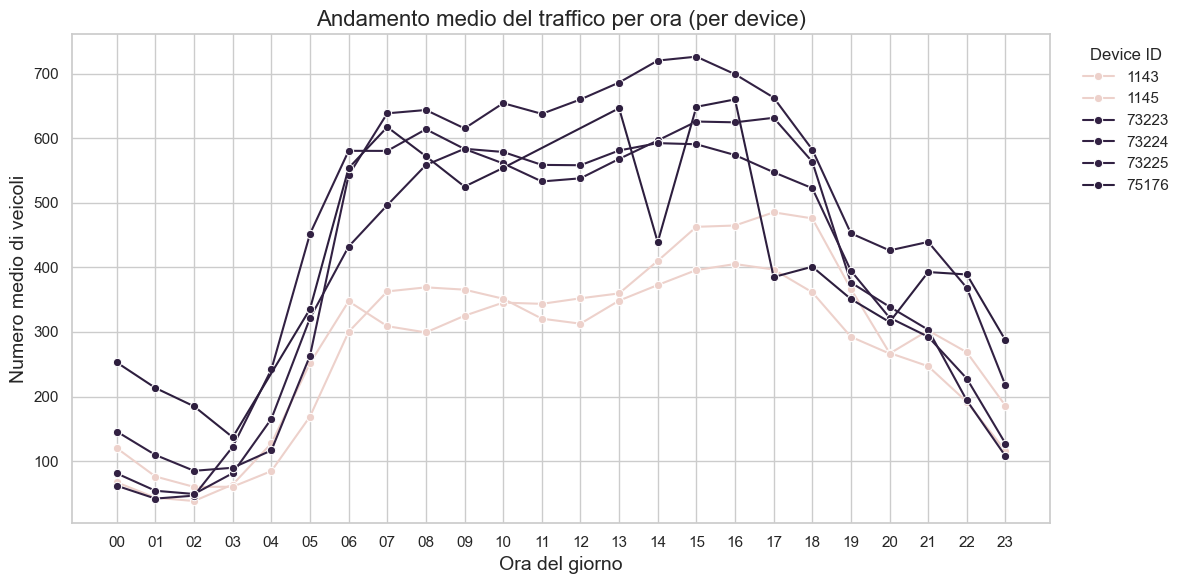

In [96]:
# prepara palette e stile
sns.set_theme(style="whitegrid", palette="tab10")
plt.figure(figsize=(12, 6))

# disegno una linea per ogni device_id
sns.lineplot(
    data=t, 
    x="ora", 
    y="value",
    hue="device_id",
    marker="o",
    legend="full"
)

# titoli e layout
plt.title("Andamento medio del traffico per ora (per device)", fontsize=16)
plt.xlabel("Ora del giorno", fontsize=14)
plt.ylabel("Numero medio di veicoli", fontsize=14)
plt.xticks(range(0,24), [f"{h:02d}" for h in range(24)])
plt.legend(title="Device ID", bbox_to_anchor=(1.02,1), loc="upper left", frameon=False)
plt.tight_layout()
plt.show()

In [101]:
# Copia i dati originali per non rischiare effetti collaterali
t = traffico.copy()

# Pipeline di trasformazioni
t = (
    t
    # 1) Converti timestamp e filtra per accuracy > 80
    .assign(timestamp_record=lambda d: pd.to_datetime(d['timestamp_record']))
    .query('accuracy > 80')
    # 2) Scegli solo le colonne di interesse
    [['timestamp_record', 'value', 'device_id', 'length', 'lanes']]
    # 3) estraggo l'ora del giorno da timestamp_record
    .assign(ora=lambda d: pd.to_datetime(d['timestamp_record']).dt.hour)
    # 4) raggruppo per device_id e ora, calcolo la media di value
    .groupby(['lanes', 'ora'], as_index=False)['value']
    .mean()
)

t

,lanes,ora,value
0,1,0,113.322581
1,1,1,82.460733
2,1,2,67.717325
3,1,3,88.968127
4,1,4,169.311224
5,1,5,338.783654
6,1,6,504.476190
7,1,7,570.740586
8,1,8,605.217742
9,1,9,597.708502


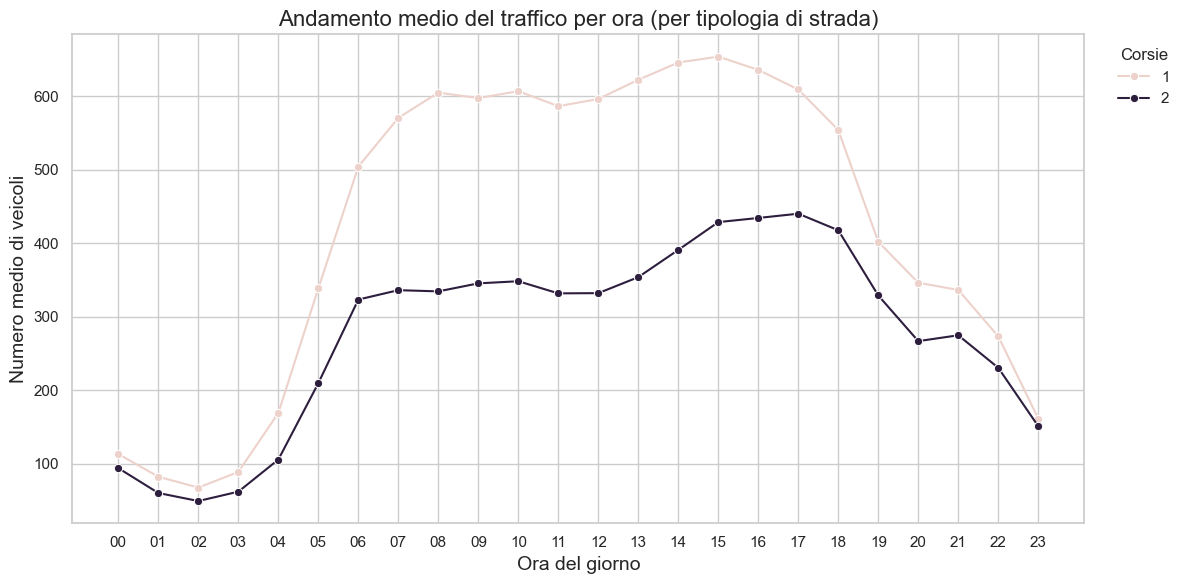

In [102]:
# prepara palette e stile
sns.set_theme(style="whitegrid", palette="tab10")
plt.figure(figsize=(12, 6))

# disegno una linea per ogni device_id
sns.lineplot(
    data=t, 
    x="ora", 
    y="value",
    hue="lanes",
    marker="o",
    legend="full"
)

# titoli e layout
plt.title("Andamento medio del traffico per ora (per tipologia di strada)", fontsize=16)
plt.xlabel("Ora del giorno", fontsize=14)
plt.ylabel("Numero medio di veicoli", fontsize=14)
plt.xticks(range(0,24), [f"{h:02d}" for h in range(24)])
plt.legend(title="Corsie", bbox_to_anchor=(1.02,1), loc="upper left", frameon=False)
plt.tight_layout()
plt.show()

In [202]:
meteo = pd.read_csv('./meteo/history_2024.csv', index_col=0)
meteo.index = pd.to_datetime(meteo.index)
meteo = meteo.resample('D').mean()
meteo

,solarRadiationHigh,humidityAvg,tempAvg,windspeedAvg,precipRate,precipTotal
2024-09-27,23.112963,68.740741,21.018519,0.543210,0.047037,0.205247
2024-09-28,20.106250,37.135417,19.809028,0.503472,0.000000,0.000000
2024-09-29,26.798958,49.500000,18.086806,0.270833,0.000000,0.000000
2024-09-30,30.454007,62.916376,17.777003,0.560976,0.000000,0.000000
2024-10-01,44.852778,68.215278,17.517361,0.201389,0.000000,0.000000
...,...,...,...,...,...,...
2024-12-27,7.003125,60.770833,4.625000,0.000000,0.000000,0.000000
2024-12-28,6.715278,55.423611,5.743056,0.006944,0.000000,0.000000
2024-12-29,6.923958,57.461806,6.583333,0.000000,0.000000,0.000000
2024-12-30,7.139583,61.479167,6.486111,0.000000,0.000000,0.000000


In [128]:
rainy_flag = meteo['precipTotal'] > 0.0
rainy = meteo[rainy_flag]
clear = meteo[~rainy_flag]
rainy_dates = rainy.index.normalize().date

In [129]:
t = traffico.copy()
t['timestamp_record'] = pd.to_datetime(t['timestamp_record'])
t['date'] = t['timestamp_record'].dt.date
rainy_traffic = t[t['date'].isin(rainy_dates)]
clear_traffic = t[~t['date'].isin(rainy_dates)]
rainy_traffic = rainy_traffic.drop(columns='date')
clear_traffic = clear_traffic.drop(columns='date')

Traffico nei giorni piovosi: (2532, 12)
Traffico nei giorni asciutti: (42338, 12)


In [130]:
rainy_traffic

,device_id,data_location_id,timestamp_record,key,value,accuracy,quality_automatic_check,quality_manual_check,id_local,id_global,length,lanes
7969,1143,pasta,2024-10-03 00:00:00+00:00,count_all,15.0,81,NaN,NaN,1143,car-1143,24,2
7970,75176,pasta,2024-10-03 00:00:00+00:00,count_all,16.0,32,False,NaN,75176,car-75176,76,1
7971,73225,pasta,2024-10-03 00:00:00+00:00,count_all,50.0,81,NaN,NaN,73225,car-73225,116,1
7972,73223,pasta,2024-10-03 00:00:00+00:00,count_all,0.0,0,False,NaN,73223,car-73223,76,1
7973,1145,pasta,2024-10-03 00:00:00+00:00,count_all,34.0,94,NaN,NaN,1145,car-1145,200,2
...,...,...,...,...,...,...,...,...,...,...,...,...
37924,73224,pasta,2024-11-22 23:00:00+00:00,count_all,340.0,73,NaN,NaN,73224,car-73224,116,1
37925,73223,pasta,2024-11-22 23:00:00+00:00,count_all,0.0,0,False,NaN,73223,car-73223,76,1
37926,1143,pasta,2024-11-22 23:00:00+00:00,count_all,249.0,100,NaN,NaN,1143,car-1143,24,2
37927,75176,pasta,2024-11-22 23:00:00+00:00,count_all,435.0,65,NaN,NaN,75176,car-75176,76,1


In [131]:
clear_traffic

,device_id,data_location_id,timestamp_record,key,value,accuracy,quality_automatic_check,quality_manual_check,id_local,id_global,length,lanes
0,73224,pasta,2024-03-31 22:00:00+00:00,count_all,61.0,80,NaN,NaN,73224,car-73224,116,1
1,1143,pasta,2024-03-31 22:00:00+00:00,count_all,116.0,98,NaN,NaN,1143,car-1143,24,2
2,73223,pasta,2024-03-31 22:00:00+00:00,count_all,53.0,80,NaN,NaN,73223,car-73223,76,1
3,73225,pasta,2024-03-31 22:00:00+00:00,count_all,116.0,80,NaN,NaN,73225,car-73225,116,1
4,1145,pasta,2024-03-31 22:00:00+00:00,count_all,217.0,100,NaN,NaN,1145,car-1145,200,2
...,...,...,...,...,...,...,...,...,...,...,...,...
44865,73223,pasta,2024-08-31 21:00:00+00:00,count_all,469.0,81,NaN,NaN,73223,car-73223,76,1
44866,1143,pasta,2024-08-31 21:00:00+00:00,count_all,322.0,100,NaN,NaN,1143,car-1143,24,2
44867,73224,pasta,2024-08-31 21:00:00+00:00,count_all,434.0,72,NaN,NaN,73224,car-73224,116,1
44868,1145,pasta,2024-08-31 21:00:00+00:00,count_all,80.0,93,NaN,NaN,1145,car-1145,200,2


In [133]:
# 1) Prepara t con tutti i campi necessari
t = (
    traffico
    .assign(
        timestamp_record=lambda d: pd.to_datetime(d['timestamp_record']),
        date=lambda d: pd.to_datetime(d['timestamp_record']).dt.date,
        ora=lambda d: pd.to_datetime(d['timestamp_record']).dt.hour
    )
    .query('accuracy > 80')
)

# 2) Traffico nei giorni piovosi
rainy_traffic = (
    t[t['date'].isin(rainy_dates)]
    .groupby(['device_id', 'ora'], as_index=False)
    .agg(
        value=('value', 'mean'),
        length=('length', 'mean'),
        lanes =('lanes', 'mean')
    )
)

# 3) Traffico nei giorni asciutti
clear_traffic = (
    t[~t['date'].isin(rainy_dates)]
    .groupby(['device_id', 'ora'], as_index=False)
    .agg(
        value=('value', 'mean'),
        length=('length', 'mean'),
        lanes =('lanes', 'mean')
    )
)

In [134]:
rainy_traffic

,device_id,ora,value,length,lanes
0,1143,0,68.000000,24.0,2.0
1,1143,1,43.400000,24.0,2.0
2,1143,2,50.750000,24.0,2.0
3,1143,3,71.250000,24.0,2.0
4,1143,4,150.153846,24.0,2.0
...,...,...,...,...,...
94,73225,22,346.875000,116.0,1.0
95,73225,23,278.727273,116.0,1.0
96,75176,7,645.000000,76.0,1.0
97,75176,16,660.000000,76.0,1.0


In [135]:
clear_traffic

,device_id,ora,value,length,lanes
0,1143,0,67.179272,24.0,2.0
1,1143,1,43.485632,24.0,2.0
2,1143,2,37.891738,24.0,2.0
3,1143,3,63.614958,24.0,2.0
4,1143,4,126.752066,24.0,2.0
...,...,...,...,...,...
135,75176,19,351.000000,76.0,1.0
136,75176,20,315.333333,76.0,1.0
137,75176,21,385.428571,76.0,1.0
138,75176,22,389.000000,76.0,1.0


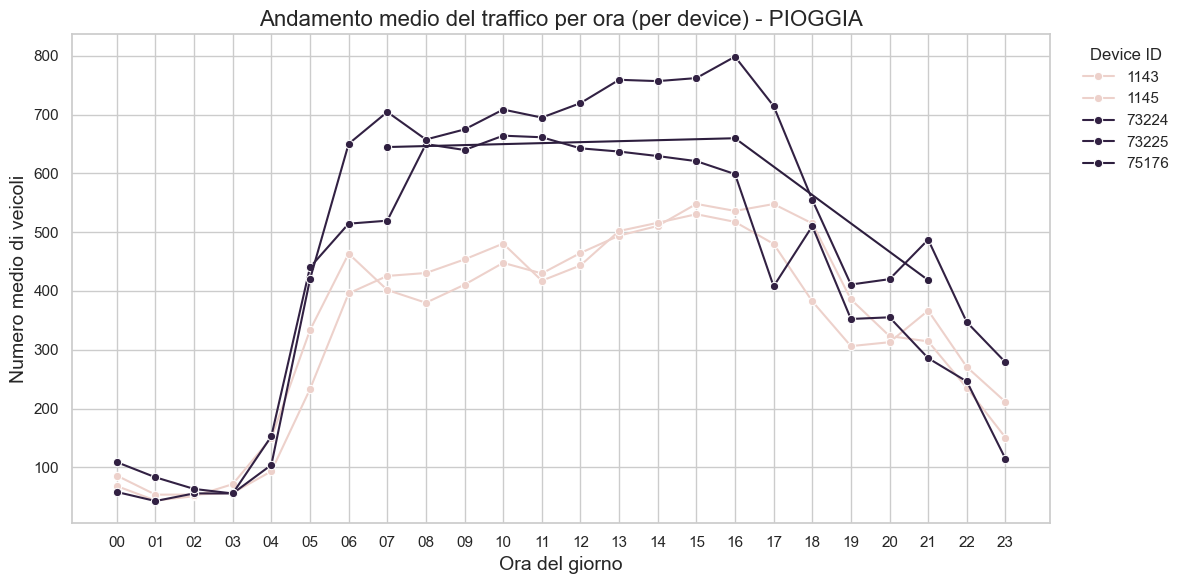

In [137]:
# prepara palette e stile
sns.set_theme(style="whitegrid", palette="tab10")
plt.figure(figsize=(12, 6))

# disegno una linea per ogni device_id
sns.lineplot(
    data=rainy_traffic, 
    x="ora", 
    y="value",
    hue="device_id",
    marker="o",
    legend="full"
)

# titoli e layout
plt.title("Andamento medio del traffico per ora (per device) - PIOGGIA", fontsize=16)
plt.xlabel("Ora del giorno", fontsize=14)
plt.ylabel("Numero medio di veicoli", fontsize=14)
plt.xticks(range(0,24), [f"{h:02d}" for h in range(24)])
plt.legend(title="Device ID", bbox_to_anchor=(1.02,1), loc="upper left", frameon=False)
plt.tight_layout()
plt.show()

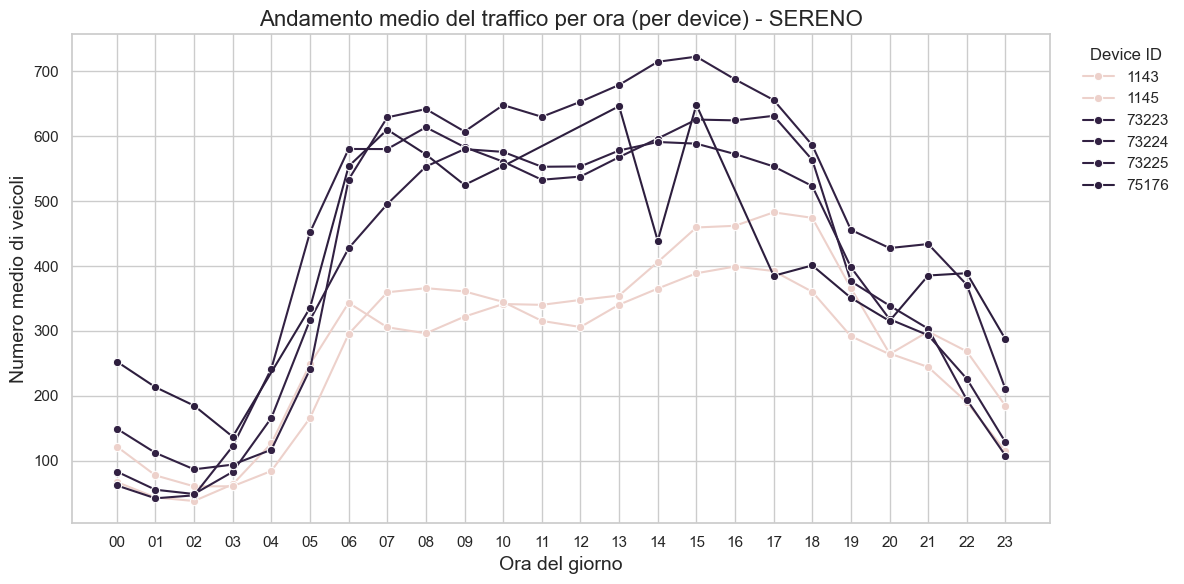

In [138]:
# prepara palette e stile
sns.set_theme(style="whitegrid", palette="tab10")
plt.figure(figsize=(12, 6))

# disegno una linea per ogni device_id
sns.lineplot(
    data=clear_traffic, 
    x="ora", 
    y="value",
    hue="device_id",
    marker="o",
    legend="full"
)

# titoli e layout
plt.title("Andamento medio del traffico per ora (per device) - SERENO", fontsize=16)
plt.xlabel("Ora del giorno", fontsize=14)
plt.ylabel("Numero medio di veicoli", fontsize=14)
plt.xticks(range(0,24), [f"{h:02d}" for h in range(24)])
plt.legend(title="Device ID", bbox_to_anchor=(1.02,1), loc="upper left", frameon=False)
plt.tight_layout()
plt.show()

In [139]:
# 1) Prepara t con tutti i campi necessari
t = (
    traffico
    .assign(
        timestamp_record=lambda d: pd.to_datetime(d['timestamp_record']),
        date=lambda d: pd.to_datetime(d['timestamp_record']).dt.date,
        ora=lambda d: pd.to_datetime(d['timestamp_record']).dt.hour
    )
    .query('accuracy > 80')
)

# 2) Traffico nei giorni piovosi
rainy_traffic = (
    t[t['date'].isin(rainy_dates)]
    .groupby(['lanes', 'ora'], as_index=False)
    .agg(
        value=('value', 'mean'),
        length=('length', 'mean'),
        lanes =('lanes', 'mean')
    )
)

# 3) Traffico nei giorni asciutti
clear_traffic = (
    t[~t['date'].isin(rainy_dates)]
    .groupby(['lanes', 'ora'], as_index=False)
    .agg(
        value=('value', 'mean'),
        length=('length', 'mean'),
        lanes =('lanes', 'mean')
    )
)

In [140]:
rainy_traffic

,ora,value,length,lanes
0,0,81.633333,116.000000,1.0
1,1,61.285714,116.000000,1.0
2,2,58.761905,116.000000,1.0
3,3,55.411765,116.000000,1.0
4,4,143.000000,116.000000,1.0
5,5,428.100000,116.000000,1.0
6,6,582.500000,116.000000,1.0
7,7,663.733333,113.333333,1.0
8,8,655.375000,116.000000,1.0
9,9,665.277778,116.000000,1.0


In [141]:
clear_traffic

,ora,value,length,lanes
0,0,115.871314,109.029491,1.0
1,1,84.135593,109.898305,1.0
2,2,68.327922,110.935065,1.0
3,3,91.405983,111.384615,1.0
4,4,170.000000,106.994764,1.0
5,5,334.272727,105.696970,1.0
6,6,500.575000,104.800000,1.0
7,7,564.513393,105.642857,1.0
8,8,601.758621,107.724138,1.0
9,9,592.397380,107.965066,1.0


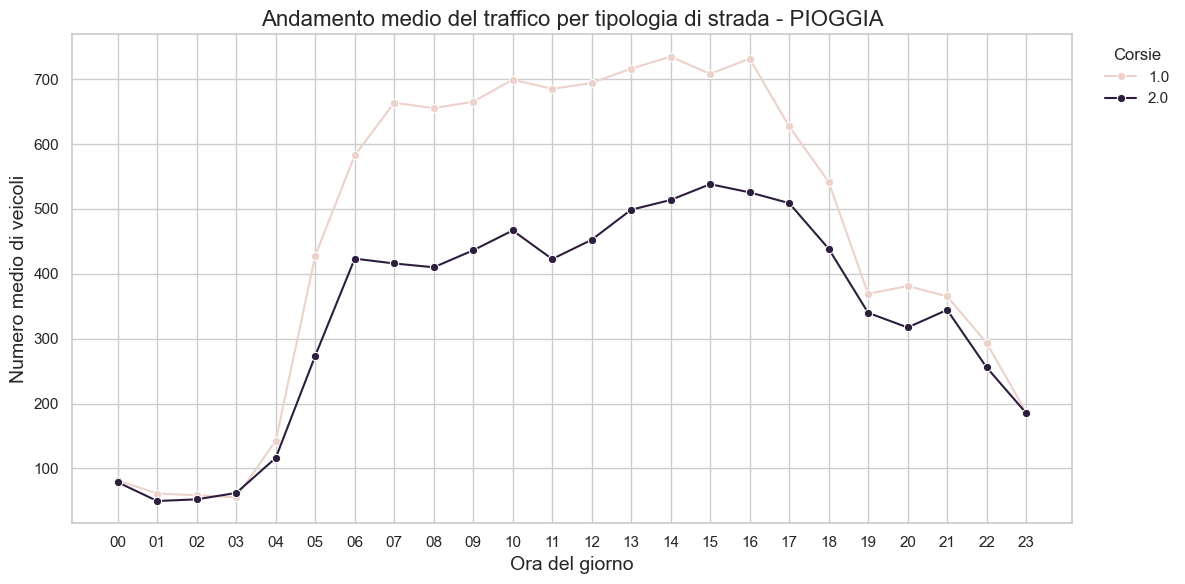

In [145]:
# prepara palette e stile
sns.set_theme(style="whitegrid", palette="tab10")
plt.figure(figsize=(12, 6))

# disegno una linea per ogni device_id
sns.lineplot(
    data=rainy_traffic, 
    x="ora", 
    y="value",
    hue="lanes",
    marker="o",
    legend="full"
)

# titoli e layout
plt.title("Andamento medio del traffico per tipologia di strada - PIOGGIA", fontsize=16)
plt.xlabel("Ora del giorno", fontsize=14)
plt.ylabel("Numero medio di veicoli", fontsize=14)
plt.xticks(range(0,24), [f"{h:02d}" for h in range(24)])
plt.legend(title="Corsie", bbox_to_anchor=(1.02,1), loc="upper left", frameon=False)
plt.tight_layout()
plt.show()

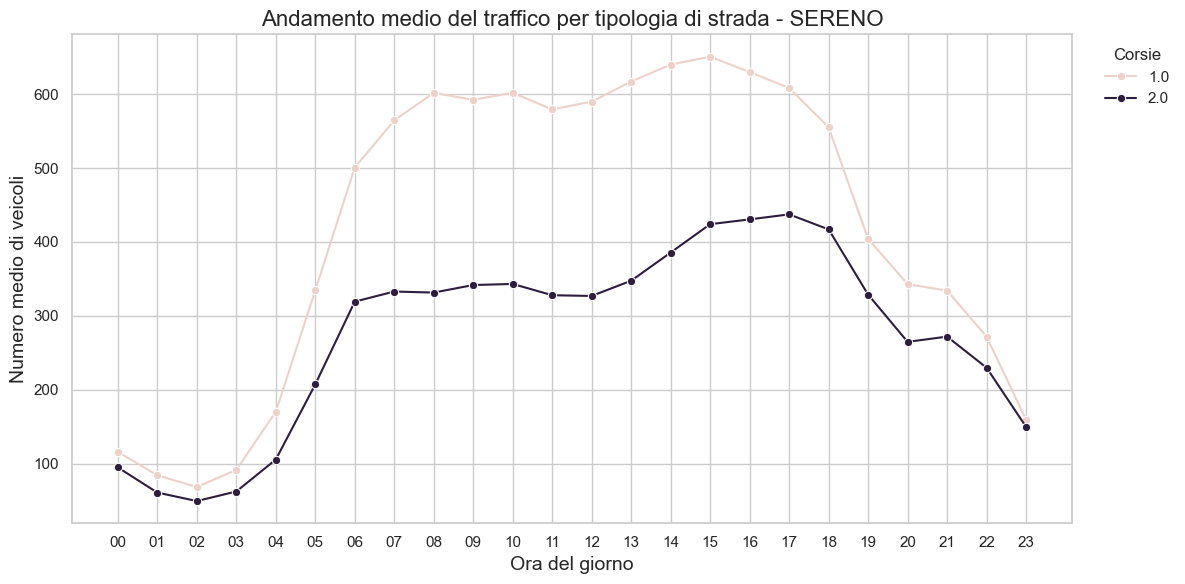

In [144]:
# prepara palette e stile
sns.set_theme(style="whitegrid", palette="tab10")
plt.figure(figsize=(12, 6))

# disegno una linea per ogni device_id
sns.lineplot(
    data=clear_traffic, 
    x="ora", 
    y="value",
    hue="lanes",
    marker="o",
    legend="full"
)

# titoli e layout
plt.title("Andamento medio del traffico per tipologia di strada - SERENO", fontsize=16)
plt.xlabel("Ora del giorno", fontsize=14)
plt.ylabel("Numero medio di veicoli", fontsize=14)
plt.xticks(range(0,24), [f"{h:02d}" for h in range(24)])
plt.legend(title="Corsie", bbox_to_anchor=(1.02,1), loc="upper left", frameon=False)
plt.tight_layout()
plt.show()

In [154]:
df_comp = (
    pd.merge(
        rainy_traffic,
        clear_traffic,
        on=['lanes', 'ora'],
        suffixes=('_rainy', '_clear')
    )
    .assign(
        delta_value=lambda d: (d['value_rainy'] - d['value_clear']) 
                              / d['value_clear'] * 100
    )
)

df_comp

,ora,value_rainy,length_rainy,lanes,value_clear,length_clear,delta_value
0,0,81.633333,116.000000,1.0,115.871314,109.029491,-29.548280
1,1,61.285714,116.000000,1.0,84.135593,109.898305,-27.158398
2,2,58.761905,116.000000,1.0,68.327922,110.935065,-14.000158
3,3,55.411765,116.000000,1.0,91.405983,111.384615,-39.378405
4,4,143.000000,116.000000,1.0,170.000000,106.994764,-15.882353
5,5,428.100000,116.000000,1.0,334.272727,105.696970,28.069078
6,6,582.500000,116.000000,1.0,500.575000,104.800000,16.366179
7,7,663.733333,113.333333,1.0,564.513393,105.642857,17.576189
8,8,655.375000,116.000000,1.0,601.758621,107.724138,8.909948
9,9,665.277778,116.000000,1.0,592.397380,107.965066,12.302620


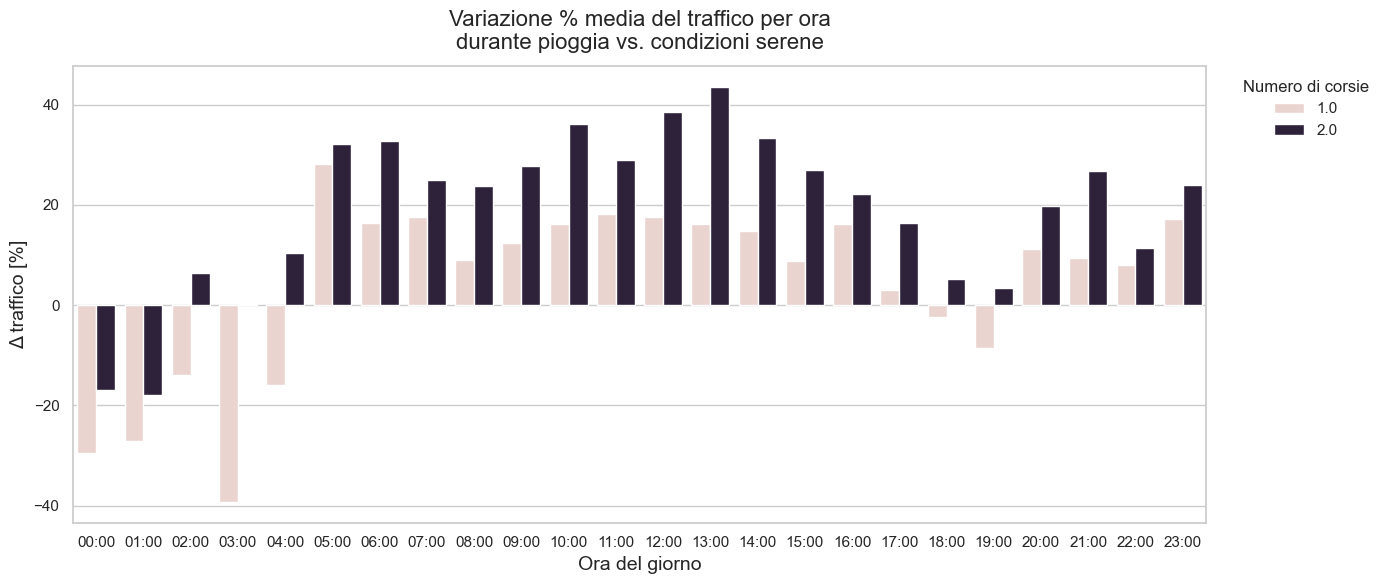

In [159]:
# 1) Imposta stile e palette
sns.set_theme(style="whitegrid", palette="tab10")
fig, ax = plt.subplots(figsize=(14, 6))

# 2) Barplot raggruppato: per ogni ora, un cluster di barre (una per 'lanes')
sns.barplot(
    data=df_comp,
    x="ora",
    y="delta_value",
    hue="lanes",
    errorbar=None,           # niente barre di errore, dato che hai già una media
    dodge=True,        # affianca le barre per ciascuna corsia
    ax=ax
)

# 3) Titoli ed etichette
ax.set_title("Variazione % media del traffico per ora\ndurante pioggia vs. condizioni serene", fontsize=16, pad=12)
ax.set_xlabel("Ora del giorno", fontsize=14)
ax.set_ylabel("Δ traffico [%]", fontsize=14)

# 4) Ticks personalizzati per le 24 ore
ax.set_xticks(range(24))
ax.set_xticklabels([f"{h:02d}:00" for h in range(24)], rotation=0)

# 5) Legenda esterna
ax.legend(
    title="Numero di corsie",
    bbox_to_anchor=(1.02, 1),
    loc="upper left",
    frameon=False
)

# 6) Layout finale
plt.tight_layout()
plt.show()

In [176]:
# 1) Pivot wide: indice=ora, colonne=lanes
wide = df_comp.pivot(index='ora', columns='lanes', values='delta_value')
wide.columns = wide.columns.astype(int)

# 2) Assicurati di avere almeno le colonne 1 e 2
wide = wide.reindex(columns=[1, 2])

# 3) Salva δ1 e δ2
delta1 = wide[1]
delta2 = wide[2]

# 4) Funzione logaritmica di estrapolazione
def delta_n(n, d1, d2):
    return d1 + (d2 - d1) * (np.log(n) / np.log(2))

# 5) Calcola per 3 e 4 corsie
wide[3] = delta_n(3, delta1, delta2)
wide[4] = delta_n(4, delta1, delta2)

# 6) Rinomina e ordina colonne
result_log = wide[[1, 2, 3, 4]].sort_index()

int(result_log)

lanes          1          2          3          4
ora                                              
0     -29.548280 -16.988459  -9.641434  -4.428637
1     -27.158398 -17.979883 -12.610796  -8.801369
2     -14.000158   6.444946  18.404566  26.890051
3     -39.378405   0.257035  23.442281  39.892475
4     -15.882353  10.395024  25.766305  36.672401
5      28.069078  32.194538  34.607777  36.319997
6      16.366179  32.652900  42.180021  48.939621
7      17.576189  24.960205  29.279578  32.344222
8       8.909948  23.727139  32.394640  38.544329
9      12.302620  27.698379  36.704321  43.094138
10     16.180111  36.048878  47.671362  55.917646
11     18.248208  28.944966  35.202169  39.641725
12     17.656368  38.443157  50.602649  59.229946
13     16.081101  43.524515  59.577884  70.967930
14     14.790533  33.249996  44.048090  51.709459
15      8.791742  26.912086  37.511808  45.032431
16     16.167917  22.079480  25.537523  27.991044
17      3.067838  16.378698  24.165052  29.689559


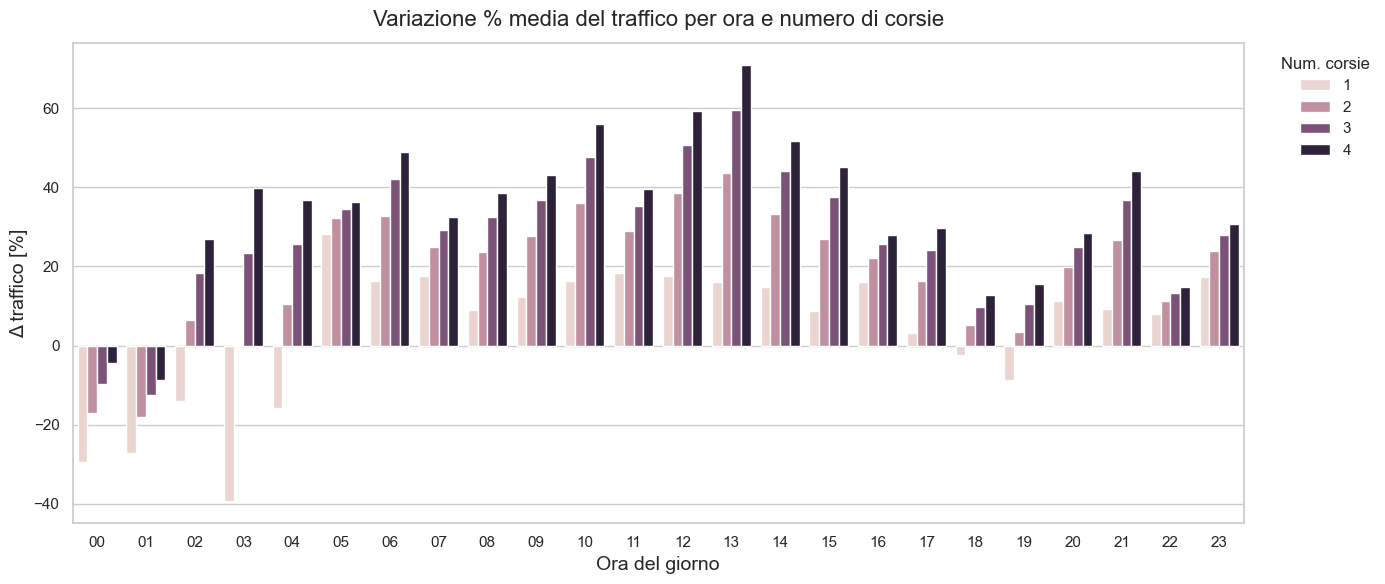

In [181]:
# 1) Trasformiamo in “long form” per seaborn
df_plot = (
    result_log
    .reset_index()                  # porta 'ora' da index a colonna
    .melt(id_vars='ora', 
          value_vars=[1,2,3,4],
          var_name='lanes', 
          value_name='delta_value')
)

# 2) Impostazioni di stile
sns.set_theme(style="whitegrid", palette="tab10")
fig, ax = plt.subplots(figsize=(14,6))

# 3) Bar plot raggruppato per ora e corsie
sns.barplot(
    data=df_plot,
    x="ora",
    y="delta_value",
    hue="lanes",
    errorbar=None,        # senza barre di errore
    dodge=True,     # affianca le barre per ciascuna categoria
    ax=ax
)

# 4) Titoli e etichette
ax.set_title("Variazione % media del traffico per ora e numero di corsie", fontsize=16, pad=12)
ax.set_xlabel("Ora del giorno", fontsize=14)
ax.set_ylabel("Δ traffico [%]", fontsize=14)
ax.set_xticks(range(24))
ax.set_xticklabels([f"{h:02d}" for h in range(24)], rotation=0)

# 5) Legenda esterna
ax.legend(
    title="Num. corsie",
    bbox_to_anchor=(1.02, 1),
    loc="upper left",
    frameon=False
)

# 6) Layout finale
plt.tight_layout()
plt.show()

In [200]:
penalties = (
    result_log
    .clip(lower=0)
    .mul(-1)
    .round(3)
    .mask(lambda df: np.isclose(df, 0.0), 0.0)
)
penalties

lanes,1,2,3,4
ora,,,,
0,0.000,0.000,0.000,0.000
1,0.000,0.000,0.000,0.000
2,0.000,-6.445,-18.405,-26.890
3,0.000,-0.257,-23.442,-39.892
4,0.000,-10.395,-25.766,-36.672
5,-28.069,-32.195,-34.608,-36.320
6,-16.366,-32.653,-42.180,-48.940
7,-17.576,-24.960,-29.280,-32.344
8,-8.910,-23.727,-32.395,-38.544


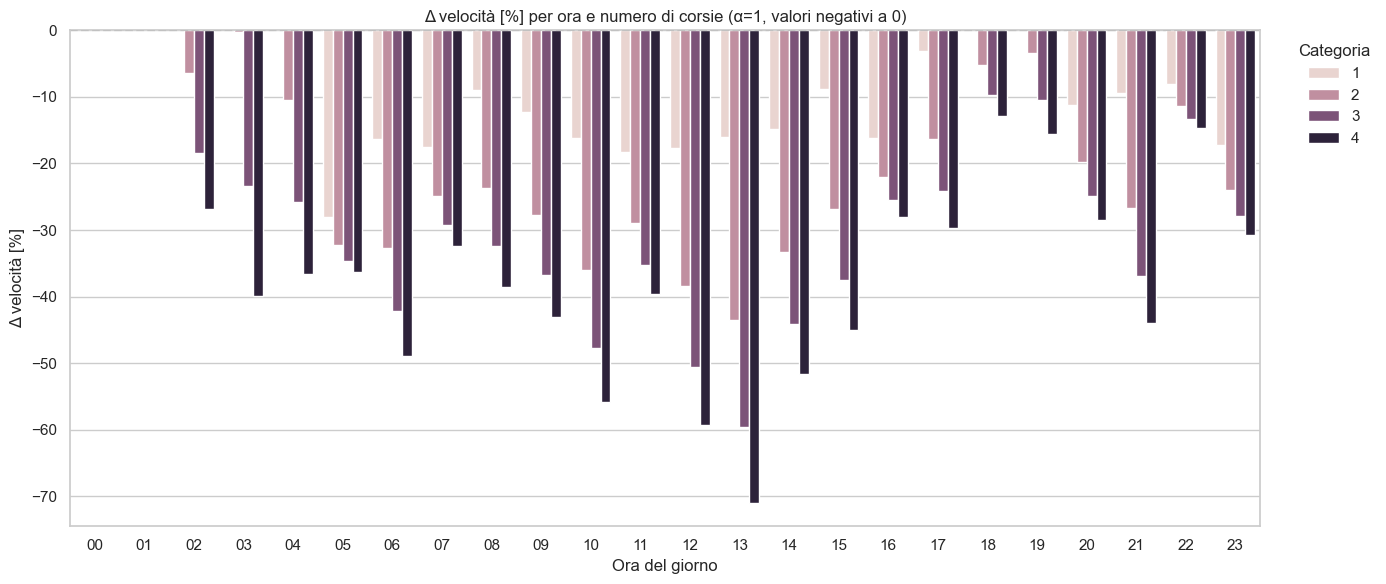

In [199]:
df_plot = (
    penalties
    .reset_index()
    .melt(id_vars='ora',
          value_vars=penalties.columns,
          var_name='lane_category',
          value_name='delta_speed')
)

sns.set_theme(style="whitegrid", palette="tab10")
plt.figure(figsize=(14,6))
sns.barplot(
    data=df_plot,
    x="ora",
    y="delta_speed",
    hue="lane_category",
    dodge=True,
    errorbar=None
)
plt.axhline(0, color="gray", linestyle="--")
plt.title("Δ velocità [%] per ora e numero di corsie (α=1, valori negativi a 0)")
plt.xlabel("Ora del giorno")
plt.ylabel("Δ velocità [%]")
plt.xticks(range(24), [f"{h:02d}" for h in range(24)])
plt.legend(title="Categoria", bbox_to_anchor=(1.02,1), loc="upper left", frameon=False)
plt.tight_layout()
plt.show()

In [201]:
penalties.to_csv('penalties.csv', index=True)